# Calculate the best-fit BT and DRIFT-PHOENIX emission spectrum models


**Author:** Hannu Parviainen<br>
**Last edited:** 26.5.2022

In [3]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
import bz2
import lzma
import seaborn as sb
import pandas as pd
import astropy.io.fits as pf

from pathlib import Path
from astropy.table import Table
from pytransit.lpf.lpf import lnlike_normal, lnlike_normal_v
from pytransit.utils.downsample import downsample_time_1d
from tqdm.auto import tqdm

from src.kelt1 import filters, filter_names, AAPGW, AAOCW, derive_qois, read_mcmc, pbcenters, pbbounds

## Define the helper functions

In [5]:
def read_and_downsample_svo_spectrum(f, max_wavelength=5000):
    df = pd.read_csv(f, comment='#', header=None, delim_whitespace=True)
    df.columns = ['wavelength', 'flux']
    df.wavelength *= 0.1
    df = df[df.wavelength < max_wavelength]
    bwk, bfk, _ = downsample_time_1d(df.wavelength.values, df.flux.values, 10, tmin=200, tmax=max_wavelength)
    return bwk, bfk

def integrate_svo_flux(f, max_wavelength=5000):
    wl, fl = read_and_downsample_svo_spectrum(f, max_wavelength)
    return array([(f(wl)*fl).sum() for f in filters])

In [6]:
def read_allard_bt_file(fname, max_wavelength: float = 5000.):
    if fname.suffix == '.bz2':
        with bz2.open(fname) as f:
            lines = f.readlines()
        nl = len(lines)
        wl, fl = zeros(nl), zeros(nl)
        for i in range(nl):
            tl, tf = lines[i].replace(b'D', b'E').split()[:2]
            wl[i] = float(tl) / 10.0
            fl[i] = 10**(float(tf) - 8.0)
    elif fname.suffix == '.xz':
        with lzma.open(fname) as f:
            lines = f.readlines()
        nl = len(lines)
        wl, fl = zeros(nl), zeros(nl)
        for i in range(nl):
            wl[i] = float(lines[i][:13]) / 10.0
            if lines[i][13] == 32:
                fl[i] = 10**(float(lines[i][14:26].replace(b'D', b'E')) - 8.0)
            else:
                fl[i] = 10**(float(lines[i][13:25].replace(b'D', b'E')) - 8.0)
    else:
        raise NotImplementedError
    m = wl < max_wavelength
    wl, fl = wl[m], fl[m]
    sids = argsort(wl)
    return wl[sids], fl[sids]

def read_and_downsample_allard_bt_file(fname, max_wavelength: float = 5000.):
    wl, fl = read_allard_bt_file(fname, max_wavelength)
    bwk, bfk, _ = downsample_time_1d(wl, fl, 10, tmin=200, tmax=max_wavelength)
    return bwk, bfk

def integrate_allard_bt_flux(fname, max_wavelength: float = 5000.):
    wl, fl = read_and_downsample_allard_bt_file(fname, max_wavelength)
    return array([(f(wl)*fl).sum() for f in filters])

## Define the stellar model spectrum directories

In [13]:
svod = Path.home() / Path('Dropbox/data/stellar_spectra')
btd = Path('/media/media/data/stellar_models/allard')

## Read in the final flux ratio estimates

In [9]:
final_qois = derive_qois(read_mcmc('results/03b_fin_emission_and_constrained_ev.nc'))
cs = [c for c in final_qois.columns if 'ted' in c and not 'log' in c]
measured_flux_ratios = final_qois[cs].median().values
measured_flux_ratio_errs = final_qois[cs].std().values

## Read in the stellar spectrum model

In [11]:
lstar1, fstar1 = read_and_downsample_svo_spectrum('data/spectra/bt-settl/lte065-4.0-0.0a+0.0.BT-NextGen.7.dat.txt')
lstar2, fstar2 = read_and_downsample_svo_spectrum('data/spectra/bt-settl/lte065-4.5-0.0a+0.0.BT-NextGen.7.dat.txt')
lstar = 0.5*(lstar1+lstar2)
fstar = 0.5*(fstar1+fstar2)

istar = 0.5*(integrate_svo_flux('data/spectra/bt-settl/lte065-4.0-0.0a+0.0.BT-NextGen.7.dat.txt') +
             integrate_svo_flux('data/spectra/bt-settl/lte065-4.5-0.0a+0.0.BT-NextGen.7.dat.txt'))

## Select the model spectrum files for the comparison

In [17]:
def filter_bt_cond(f):
    teff = 100*float(f.name[3:6])
    logg = float(f.name[7:10])
    metal = float(f.name[10:14])
    if (2800 <= teff <= 3200) and (4.5 <= logg <= 5.0) and (-0.1 <= metal <= 0.1):
        return True
    else:
        return False
    
def filter_bt_settl(f):
    teff = 100*float(f.name[3:8])
    logg = float(f.name[9:12])
    metal = float(f.name[13:15])
    if (2800 <= teff <= 3200) and (4.5 <= logg <= 5.0) and (-0.1 <= metal <= 0.1):
        return True
    else:
        return False

files = {}
files['bt-cond'] = sorted(filter(filter_bt_cond, (btd / 'BT-Cond').glob('*.bz2')))
files['bt-dusty'] = sorted(filter(filter_bt_cond, (btd / 'BT-Dusty').glob('*.bz2')))
files['bt-nextgen'] = sorted(filter(filter_bt_cond, (btd / 'BT-NextGen').glob('*.bz2')))
files['bt-settl'] = sorted(filter(filter_bt_settl, (btd / 'BT-Settl').glob('*.xz')))
files['drift-phoenix'] = sorted((svod / 'drift-phoenix').glob('*'))

## Calculate the log likelihoods for all the models

In [19]:
lnlike = {}
for model in files.keys():
    lnlike[model] = zeros(len(files[model]))
    for i,f in enumerate(tqdm(files[model])):
        if 'bt' in model:
            fratio = integrate_allard_bt_flux(f) / istar
        else:
            fratio = integrate_svo_flux(f) / istar
        lnlike[model][i] = lnlike_normal(measured_flux_ratios, fratio, measured_flux_ratio_errs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [20]:
{k:v.max() for k, v in lnlike.items()}

{'bt-cond': 10.028286241733275,
 'bt-dusty': 9.870676617317773,
 'bt-nextgen': 10.028286241733275,
 'bt-settl': 9.420974097592852,
 'drift-phoenix': 5.268806732314731}

In [26]:
best_fit_files = {k:files[k][v.argmax()] for k, v in lnlike.items()}
for m,f in best_fit_files.items():
    print(f"{m:15} {f.name:20}")

bt-cond         lte031-5.0-0.0a+0.0.BT-Cond.7.bz2
bt-dusty        lte031-5.0-0.0.BT-Dusty.spec.7.bz2
bt-nextgen      lte031-5.0-0.0a+0.0.BT-NextGen.7.bz2
bt-settl        lte031.0-4.5-0.0a+0.0.BT-Settl.spec.7.xz
drift-phoenix   lte_3000_4.5+0.3.7.dat.txt


## Plot the best-fit models

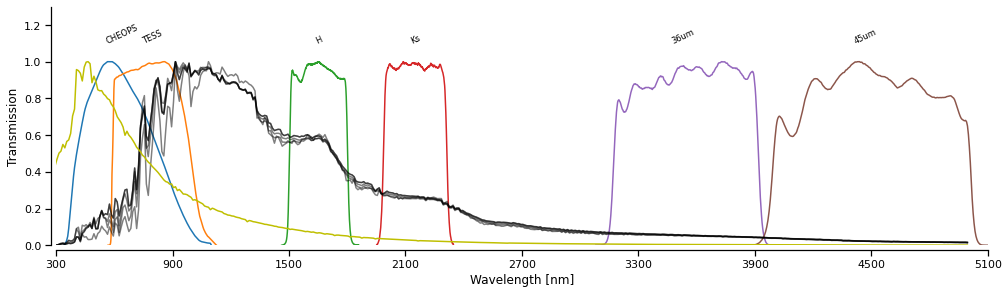

In [45]:
with sb.plotting_context('notebook'):
    fig, ax = subplots(figsize=(2*AAPGW, 2*0.3*AAPGW))
    width = 0.9
    for i, (f, fn) in enumerate(zip(filters, filter_names)):
        ax.plot(f.wavelength, f.transmission)
        ax.text(pbcenters[i], 1.1, fn, ha='center', rotation=25, size='x-small')
        
    for model,fname in best_fit_files.items():
        if 'bt' in model:
            wl, fl = read_and_downsample_allard_bt_file(fname)
        else:
            wl, fl = read_and_downsample_svo_spectrum(fname)
        ax.plot(wl, fl / fl.max(), c='k', alpha=0.5)
        
    ax.plot(wl, fstar/fstar.max(), c='y')

    setp(ax, xlabel="Wavelength [nm]", ylabel='Transmission', ylim=(0, 1.3), xlim=(300,5100),
        xticks=linspace(300, 5100, 9))
    sb.despine(fig, offset=5)
    fig.tight_layout()

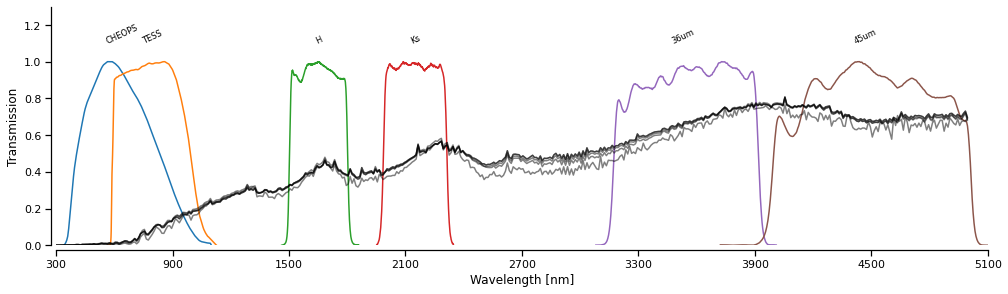

In [46]:
with sb.plotting_context('notebook'):
    fig, ax = subplots(figsize=(2*AAPGW, 2*0.3*AAPGW))
    width = 0.9
    for i, (f, fn) in enumerate(zip(filters, filter_names)):
        ax.plot(f.wavelength, f.transmission)
        ax.text(pbcenters[i], 1.1, fn, ha='center', rotation=25, size='x-small')
        
    for model,fname in best_fit_files.items():
        if 'bt' in model:
            wl, fl = read_and_downsample_allard_bt_file(fname)
        else:
            wl, fl = read_and_downsample_svo_spectrum(fname)
        ax.plot(wl, 2*fl / fstar, c='k', alpha=0.5)
        
    setp(ax, xlabel="Wavelength [nm]", ylabel='Transmission', ylim=(0, 1.3), xlim=(300,5100),
        xticks=linspace(300, 5100, 9))
    sb.despine(fig, offset=5)
    fig.tight_layout()

## Calculate the flux ratios

In [31]:
fratios = {}
for model,fname in best_fit_files.items():
    if 'bt' in model:
        fratios[model] = integrate_allard_bt_flux(fname) / istar
    else:
        fratios[model] = integrate_svo_flux(fname) / istar

In [32]:
fratios

{'bt-cond': array([0.01283965, 0.03471232, 0.19730193, 0.23869459, 0.32629212,
        0.36094303]),
 'bt-dusty': array([0.01255649, 0.03491574, 0.19562992, 0.23693215, 0.32277133,
        0.35726318]),
 'bt-nextgen': array([0.01283965, 0.03471232, 0.19730193, 0.23869459, 0.32629212,
        0.36094303]),
 'bt-settl': array([0.01242033, 0.03470958, 0.20061398, 0.23982839, 0.31989867,
        0.35713134]),
 'drift-phoenix': array([0.00847944, 0.02635523, 0.18870838, 0.22710903, 0.30273509,
        0.33897185])}

---

<center>&copy;2022 Hannu Parviainen</center>